# Appendix S3. Results appendix

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sys
import os

sys.path.append("..")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'

In [2]:
from config import SCHEME_87, ROOT

/Users/songshgeo/opt/anaconda3/envs/WAInstitution_YRB_2021/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Parallel in economic trend

**Abstract:**
One-sentence description

**Description:**
In the following cell, I...


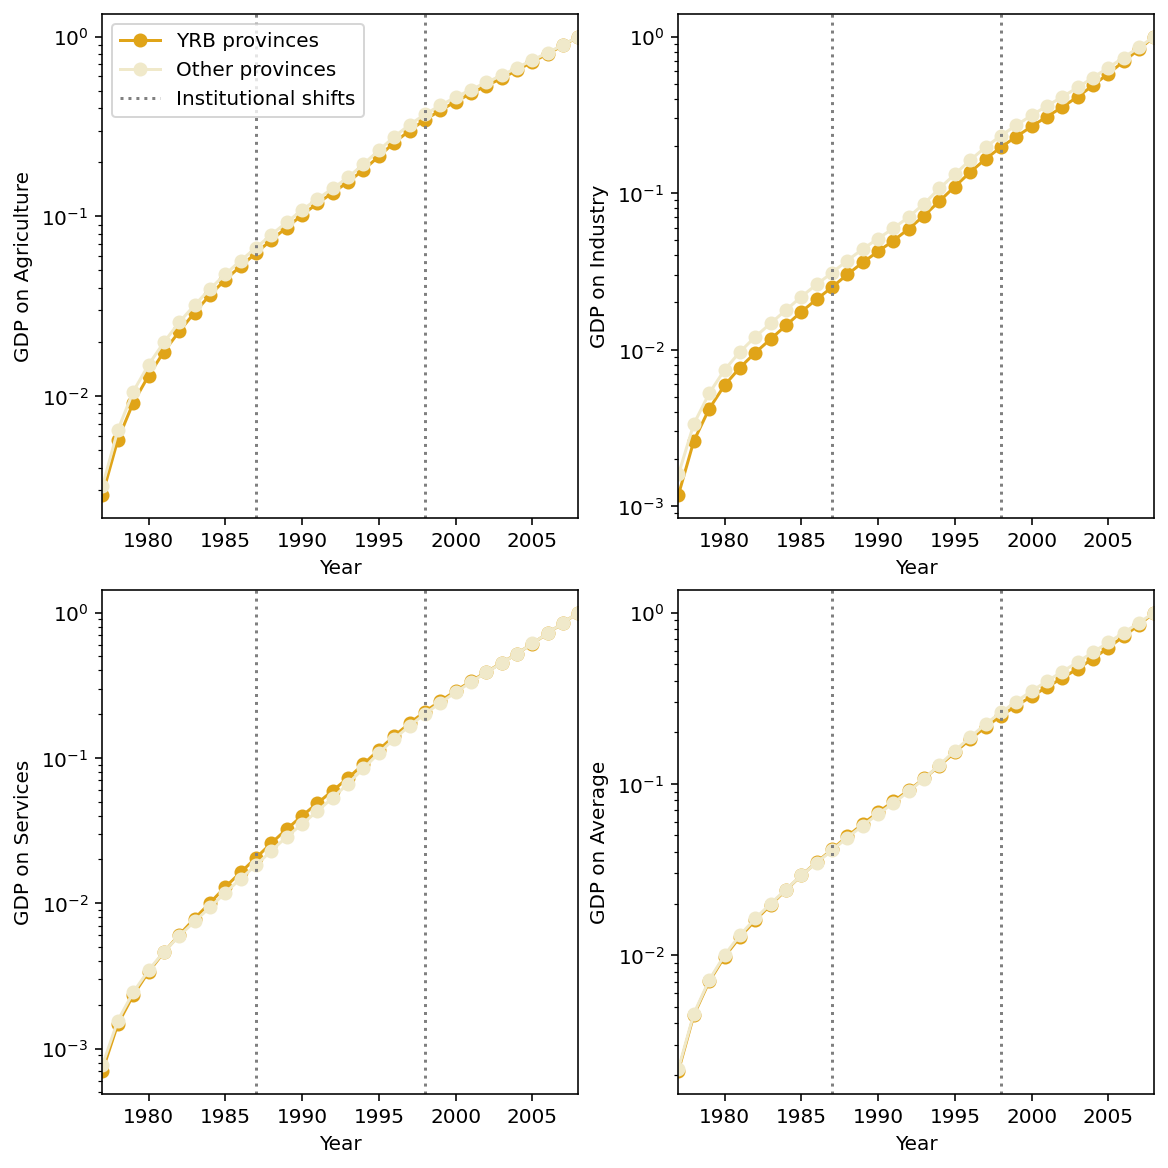

In [3]:
merged_data = pd.read_csv("../data/processed/merged_data.csv", index_col=0)
gdp_cols = []
for col in merged_data.columns:
    if 'gdp' in col:
        gdp_cols.append(col)

merged_data['YRB'] = merged_data['Province'].isin(SCHEME_87.keys())
yr_pivot = pd.pivot_table(merged_data[merged_data["YRB"]], index=["Year"], values=gdp_cols, aggfunc=np.mean).loc[1977: 2008]
other_pivot = pd.pivot_table(merged_data[~merged_data["YRB"]], index=["Year"], values=gdp_cols, aggfunc=np.mean).loc[1977: 2008]

cols = ['Agriculture', 'Industry', 'Services', 'Average']
col = 'gdp-1'

fig, (axs1, axs2) = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)
for i, ax in enumerate([*axs1, *axs2]):
    col = gdp_cols[1:][i]
    cum_yr = yr_pivot[col].cumsum() / yr_pivot[col].sum()
    cum_other = other_pivot[col].cumsum() / other_pivot[col].sum()
    
    ax.plot(cum_yr.index, cum_yr.values, "-o", color='#e0a418', label='YRB provinces')
    ax.plot(cum_other.index, cum_other.values, "-o", color='#f0e9ca', label='Other provinces')
    ax.set_yscale('log')
    ax.set_ylabel(f"GDP on {cols[i]}")
    ax.set_xlabel("Year")
    ax.set_xlim(1977, 2008)
    ax.axvline(1987, ls=":", color='gray', label='Institutional shifts')
    ax.axvline(1998, ls=":", color='gray')
    
axs1[0].legend()
plt.savefig("../figs/outputs/economy.pdf", format='pdf')
plt.show();

**Output digestion:**

---
**Analysis:**
1. Here, similar trend in GDP between the YRB provinces and other provinces indicate no obvious change after the institutional shifts.
2. Thus, economic factors contributes few in changes of water uses of the YRB. 
3. 

## GAM-WUI

**Abstract:**
Analysis WUI changes.

**Description:**
In the following cell, I...


In [4]:
from func.tools import plot_gam_and_interval
?plot_gam_and_interval

Signature:
plot_gam_and_interval(
    x,
    y,
    main_color='#29303C',
    err_color='gray',
    width=0.95,
    ax=None,
    err_space=True,
    alpha=0.1,
    scatter_alpha=0.8,
    y_label='Y',
)
Docstring: <no docstring>
File:      ~/Documents/Pycharm/WAInstitution_YRB_2021/func/tools.py
Type:      function


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


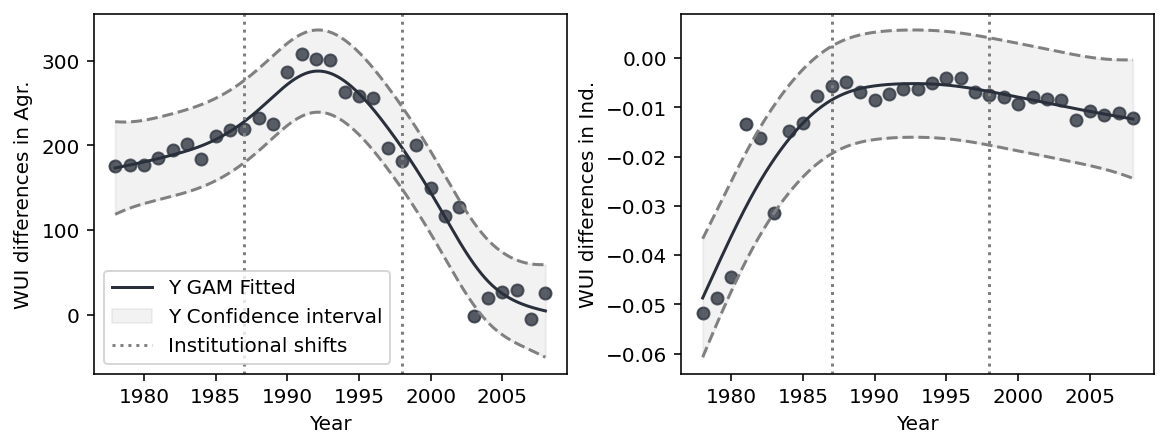

In [5]:
values_data = pd.read_csv("../data/processed/values_data.csv", index_col=0)

from config import SCHEME_87
other_provinces = list(set(values_data['Province_n'].unique()) - set(SCHEME_87.keys()))

wui_data = {}
for col in values_data.columns.to_list():
    if 'WUI' in col and 'Total' in col:
        wui = values_data.groupby(['Year', 'Province_n'])[col].mean()
        wui_data[col] = wui

data = pd.DataFrame()
for y in range(1978, 2009):
    for col in wui_data:
        data.loc[y, col+"_yr"] = wui_data[col][y][SCHEME_87.keys()].mean()
        data.loc[y, col+"_other"] = wui_data[col][y][other_provinces].mean()

# data[['Irrigation water-use intensity (WUI): Total_yr', 'Irrigation water-use intensity (WUI): Total_other']].plot()
irr_wui = (data['Irrigation water-use intensity (WUI): Total_yr'] - data['Irrigation water-use intensity (WUI): Total_other'])
# data[['Industrial WUI: Total_yr', 'Industrial WUI: Total_other']].plot()
ind_wui = (data['Industrial WUI: Total_yr'] - data['Industrial WUI: Total_other'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
plot_gam_and_interval(np.array(irr_wui.index), irr_wui.values, ax=ax1)
plot_gam_and_interval(np.array(ind_wui.index), ind_wui.values, ax=ax2)

for ax in [ax1, ax2]:
    ax.axvline(1987, ls=':', color='gray', label='Institutional shifts')
    ax.axvline(1998, ls=':', color='gray')
    ax.set_xlabel("Year")

ax1.set_ylabel("WUI differences in Agr.")
ax2.set_ylabel("WUI differences in Ind.")
ax1.legend()
plt.savefig("../figs/outputs/S3_wui.pdf", format='pdf')
plt.show();

## Expansion of Agriculture

**Abstract:**
The ratio between the area equipped for water-conserving irrigation and total irrigated area, where water-conserving irrigation technologies refer to drip or sprinkler irrigation systems and canal lining

**Description:**
In the following cell, I...


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


diff


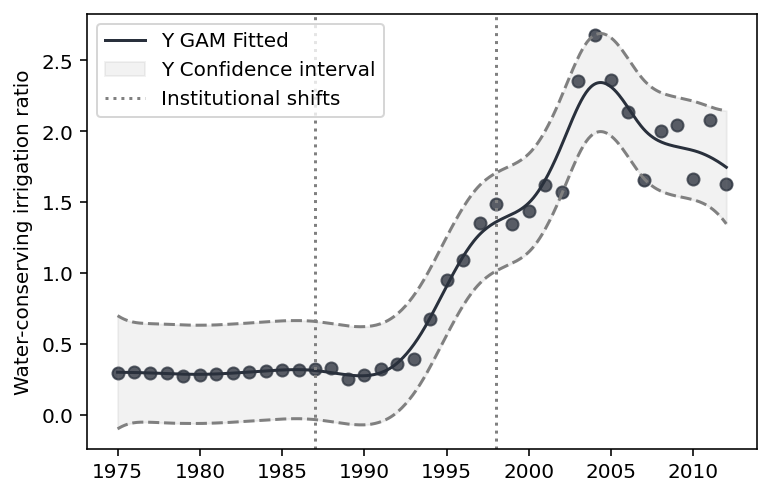

In [21]:
def compare_yr_others_in_merged_dataset(col, ax=None, color_yr='black', color_others='gray', how='mean', start=1987, end=1998):
    from scipy import stats
    if col not in merged_data:
        raise f"{col} not in the dataset."
    if not ax:
        _, ax = plt.subplots()
        
    if how == 'mean':
        yr = merged_data[merged_data['YRB']].groupby('Year')[col].mean()
        others = merged_data[~merged_data['YRB']].groupby('Year')[col].mean()
    elif how == 'cumsum':
        yr = merged_data[merged_data['YRB']].groupby('Year')[col].sum()
        others = merged_data[~merged_data['YRB']].groupby('Year')[col].sum()
        yr = yr.cumsum() / yr.sum()
        others = others.cumsum() / others.sum()
    elif how == 'diff':
        yr = merged_data[merged_data['YRB']].groupby('Year')[col].mean()
        others = merged_data[~merged_data['YRB']].groupby('Year')[col].mean()
        diff = ((yr - others)/(yr.mean() - others.mean())).dropna(how='any')
        plot_gam_and_interval(np.array(diff.index), diff.values, ax=ax)
        ax.axvline(1987, ls=':', color='gray', label='Institutional shifts')
        ax.axvline(1998, ls=':', color='gray')
        return "diff"

    ax.plot(yr.index, yr.values, "-o", color=color_yr, label='YRB provinces')
    ax.plot(others.index, others.values, "-o", color=color_others, label='Other provinces')
    
    ax.axvline(1987, ls=':', color='gray', label='Institutional shift')
    ax.axvline(1998, ls=':', color='gray')
    ax.set_xlabel("Year")
    ax.set_ylabel(col)
    
    t, p_val = stats.ttest_rel(yr.loc[start: end].values, others.loc[start: end].values)
    return p_val


    
fig, ax = plt.subplots()
p_val = compare_yr_others_in_merged_dataset("WCI", how='diff', ax=ax)
print(p_val)
ax.legend(loc=2)
ax.set_ylabel("Water-conserving irrigation ratio")

plt.savefig("../figs/outputs/S3_wci.pdf", format='pdf')
plt.show();

In [22]:
merged_data['irr_wui'] = merged_data['IRR'] / merged_data['Irrigated area: Total']

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


'diff'

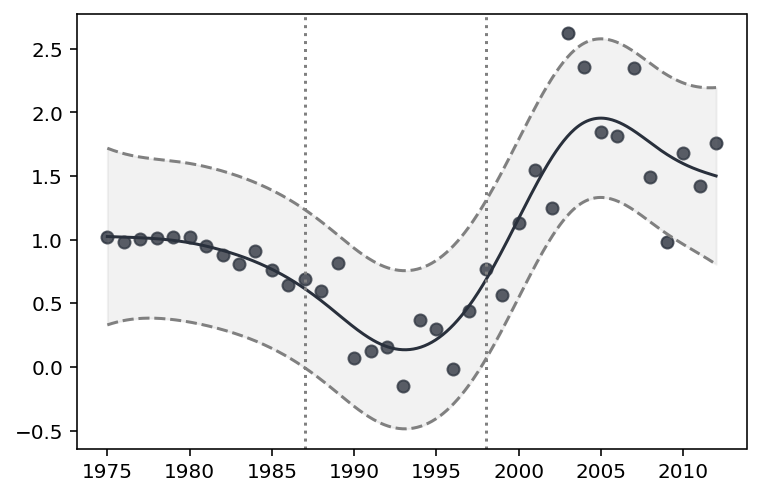

In [23]:
compare_yr_others_in_merged_dataset('irr_wui', how='diff')

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


'diff'

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


'diff'

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


'diff'

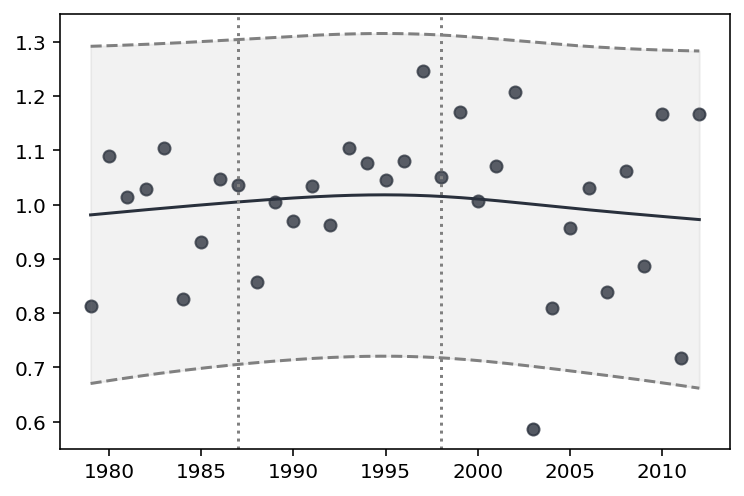

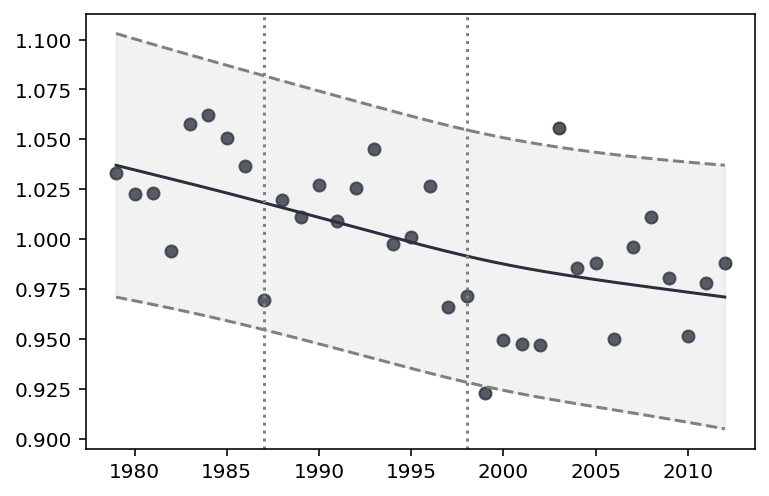

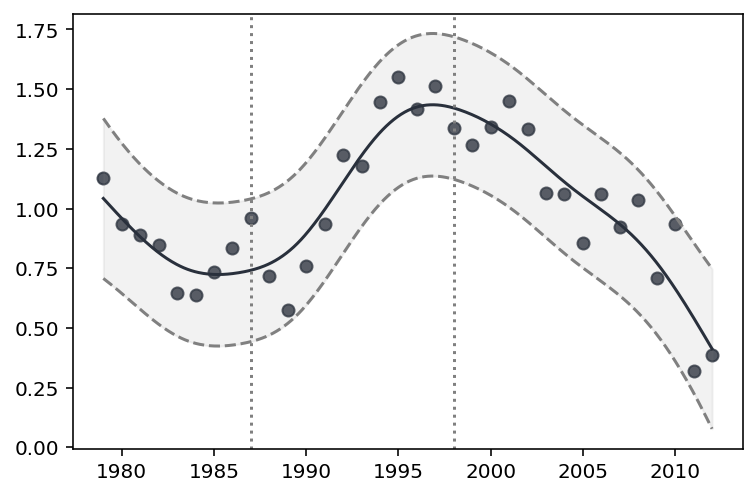

In [24]:
compare_yr_others_in_merged_dataset('prec', how='diff')
compare_yr_others_in_merged_dataset('temp', how='diff')
compare_yr_others_in_merged_dataset('wind', how='diff')

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


'diff'

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


'diff'

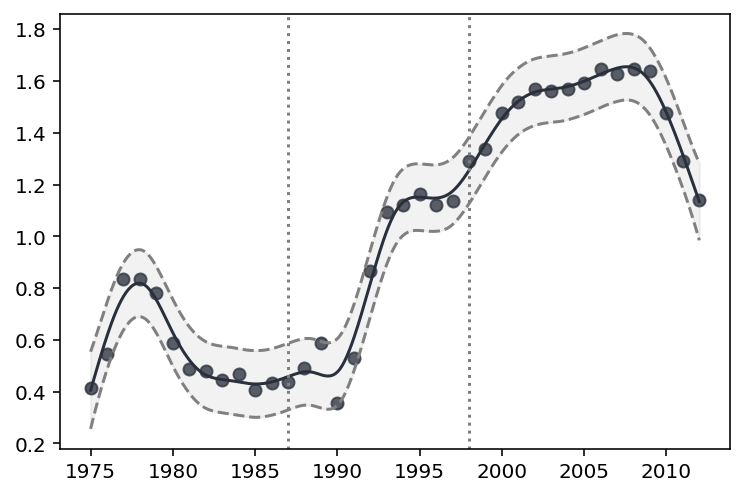

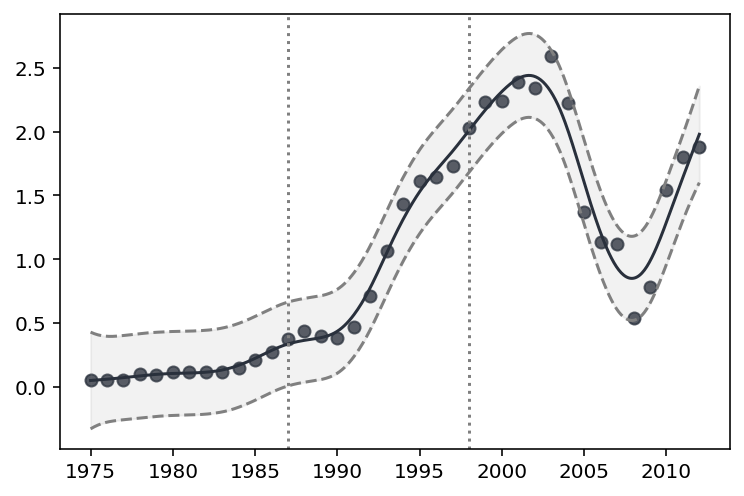

In [25]:
compare_yr_others_in_merged_dataset("Irrigated area: Total", how='diff')
compare_yr_others_in_merged_dataset('Industrial gross value added (GVA): Total', how='diff')

In [27]:
merged_data.columns

Index(['Province', 'Year', 'IRR', 'Irrigated area: Total',
       'Irrigated area: Rice', 'Irrigated area: Wheat',
       'Irrigated area: Maize', 'Irrigated area: Vegetables and fruits',
       'Irrigated area: Others', 'IND',
       'Industrial gross value added (GVA): Total',
       'Industrial gross value added (GVA): Textile',
       'Industrial gross value added (GVA): Papermaking',
       'Industrial gross value added (GVA): Petrochemicals',
       'Industrial gross value added (GVA): Metallurgy',
       'Industrial gross value added (GVA): Mining',
       'Industrial gross value added (GVA): Food',
       'Industrial gross value added (GVA): Cements',
       'Industrial gross value added (GVA): Machinery',
       'Industrial gross value added (GVA): Electronics',
       'Industrial gross value added (GVA): Thermal electrivity',
       'Industrial gross value added (GVA): Others', 'URB', 'Urban population',
       'Service GVA', 'RUR', 'Rural population', 'Livestock population',

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


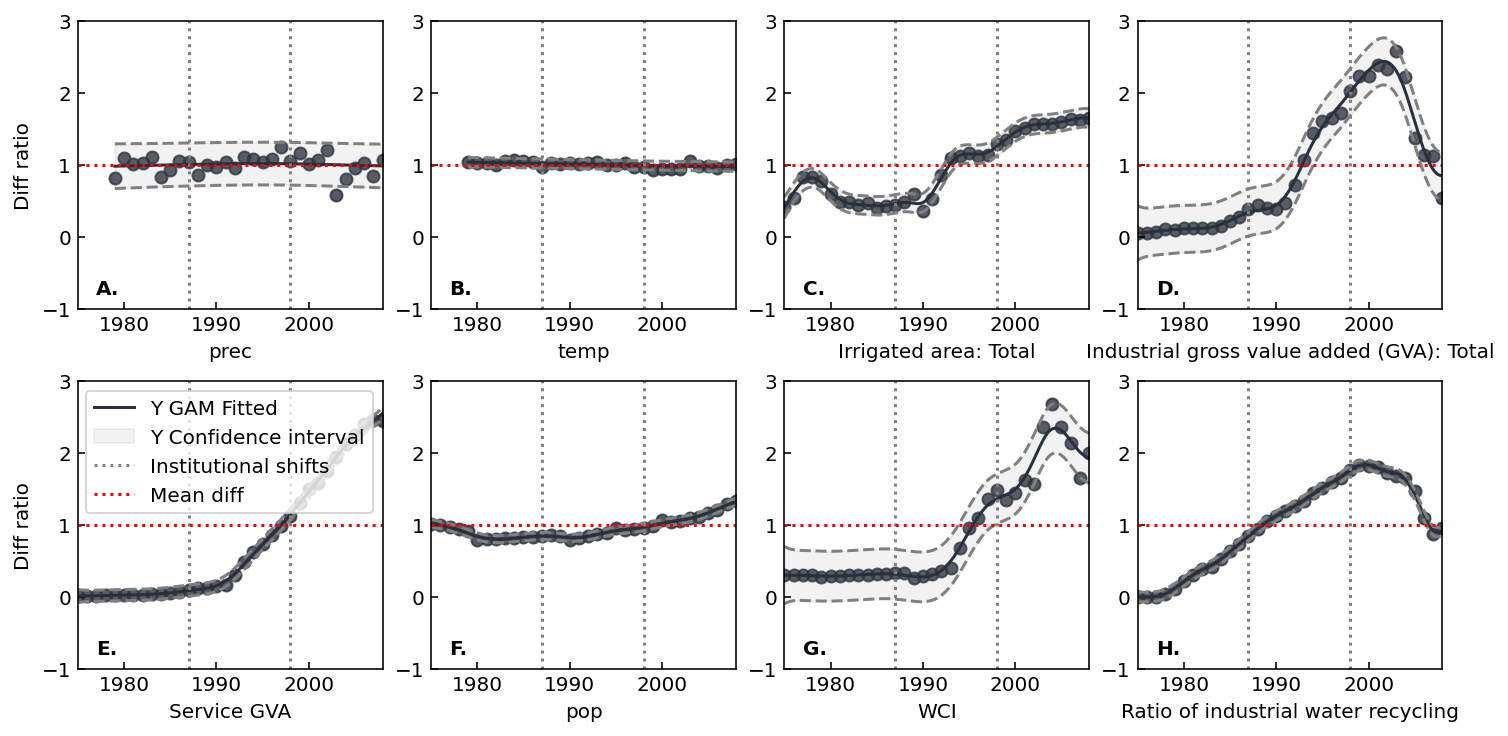

In [53]:
merged_data['pop'] = merged_data['Rural population'] + merged_data['Urban population']
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

fig, (axs1, axs2) = plt.subplots(2, 4, figsize=(10, 5), constrained_layout=True)
var = ['prec', 'temp', 'Irrigated area: Total', 'Industrial gross value added (GVA): Total', 'Service GVA', 'pop', 'WCI', 'Ratio of industrial water recycling']
labels = 'ABCDEFGH'
for i, ax in enumerate([*axs1, *axs2]):
    compare_yr_others_in_merged_dataset(var[i], ax=ax, how='diff')
    ax.set_ylim(-1, 3)
    ax.set_xlim(1975, 2008)
    ax.set_xlabel(var[i])
    ax.axhline(1, ls=":", color='red', label='Mean diff')
    ax.text(1977, -0.8, f'{labels[i]}.', weight='bold')
axs1[0].set_ylabel("Diff ratio")
axs2[0].set_ylabel("Diff ratio")
axs2[0].legend()
plt.savefig("../figs/outputs/variables.pdf", format='pdf')
plt.show();

## WCI for each province

**Abstract:**
One-sentence description

**Description:**
In the following cell, I...


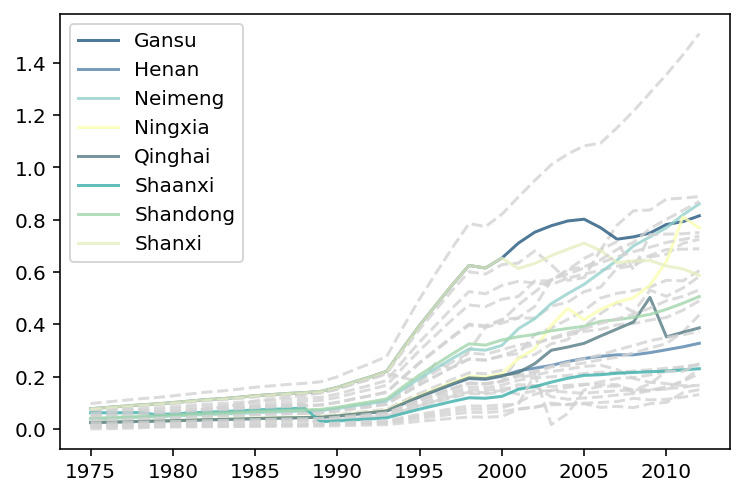

In [26]:
fig, ax = plt.subplots()

colors = ['22577E', '5584AC', '95D1CC', 'FAFFAF', '557B83', '39AEA9', 'A2D5AB', 'E5EFC1', 'C1F8CF']
x = merged_data.Year.unique()
i = 0
for province in merged_data.Province.unique():
    y = merged_data[merged_data['Province'] == province]['WCI'].values
    if province in SCHEME_87.keys():
        color = f"#{colors[i]}"
        ax.plot(x, y, color=color, label=province, alpha=.8)
        i += 1
    else:
        color = 'lightgray'
        ax.plot(x, y, color=color, ls='--', alpha=.8)
ax.legend()
plt.show();